In [1]:
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

2021-10-09 03:58:10.383219: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Loading seen/open dataset and unseen/closed dataset

In [2]:
import os  
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Loading np array from images
def make_dataset(labels, dir_path, IMG_SIZE = 150):
    # initial an empty list X to store image of np.array()
    X = []

    # initial an empty list Z to store labels/names of cat individauls
    Z = []
    for label in labels:
        DIR = dir_path + label
        for img in tqdm(os.listdir(DIR)):
            path = os.path.join(DIR,img)
            # reading images
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            # resizing images to (150, 150, 3), 3 is the number of channels - RGB
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
            X.append(np.array(img))
            Z.append(str(label)) 
    ## Transform labels in Z to Y from class 0 to class 9, as 10 different cat individuals
    le=LabelEncoder()
    Y=le.fit_transform(Z)

    ## Transform and normalize X in the range of [0, 1]
    X=np.array(X)
    X=X/255.
    return X, Y

In [3]:
dir_path = '/kaggle/input/squirrel-monkey/Saimiri sciureus/'
IMG_SIZE = 150

# 44 monkey individuals, randomly select seen datset and unseen dataset
# make open set and unseen set 
def make_seen_unseen(num_classes, seen_ratio):
    arr = np.arange(num_classes)
    np.random.shuffle(arr)
    
    labels_seen = [str(i) for i in arr[:int(num_classes * seen_ratio)]]
    labels_unseen = [str(i) for i in arr[int(num_classes * seen_ratio):]]
    
    X_seen, Y_seen = make_dataset(labels_seen, dir_path)
    X_unseen, Y_unseen = make_dataset(labels_unseen, dir_path)
    return X_seen, Y_seen, X_unseen, Y_unseen

# VGG 16 - Classification

In [4]:
def train_vgg16_model(lr = 1e-3):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize,imsize,3),
                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_vgg_16 = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(units=len(Y_seen), activation='softmax')
    ])
    model_vgg_16.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['acc']) 
    model_vgg_16.fit(x=x_train,
                     y=y_train,
                     epochs=EPOCHS,
                     batch_size=batch_size,
                     verbose=1)

    acc = round(model_vgg_16.evaluate(x_test, y_test)[1], 2)
    print('The accuracy on the Closed Dataset with VGG16 classification is {}'.format(acc))
    return model_vgg_16, acc

# Constractive Loss

In [5]:
# Helper Function 

# Create positive pairs and negative pairs
import random
def create_pairs(images, labels):
    numClasses = len(np.unique(Y_seen))
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive (0) or negative (1)
    np.random.seed(2021)
    pairImages = []
    pairLabels = []
    
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    idx = [np.where(labels == i)[0] for i in range(numClasses)]
    
    # loop voer all images
    for idxA in range(len(images)):
        # grab the current image and label belonging to the current iteration
        currentImage = images[idxA]
        label = labels[idxA]
        
        # randomly pick on an image that belongs to the *same* class label
        posId = random.choice(idx[label])
        posImage = images[posId]
        
        # prepare a positive pair and update the images and labels
        pairImages.append([currentImage, posImage])
        pairLabels.append([0])
        
        # grab the indices for each of the class labels *not* equal to
        # the current label and randomly pick an image corresponding
        # to a label *not* equal to the current label
        negId = np.where(labels != label)[0]
        negIdx = random.choice(negId)
        negImage = images[negIdx]
        
        # prepare a negative pair of images and update out lists
        pairImages.append([currentImage, negImage])
        pairLabels.append([1])
    
    return (np.array(pairImages), np.array(pairLabels))



# Function to calculate the distance between two images (Euclidean Distance used here)
import tensorflow.keras.backend as K
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
                       keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))


# contrastive loss function
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean((1 - y) * squaredPreds + y * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss


# train the model using VGG 16 base model
def train_cl_model(lr = 5e-5):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                  input_shape = (imsize,imsize,3),
                  weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    

    model_cl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    
    imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    
    featsA = model_cl(imgA)
    featsB = model_cl(imgB)
   
    distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
    model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
    model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

    model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
               batch_size = batch_size, 
               epochs=EPOCHS, 
               verbose=1)
    return model_cl

In [6]:
# accuracy function - contrastive loss

import pylab as plot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def acc_cl(x_test, y_test, X_unseen, Y_unseen, k = 1, d_t = 1):
    embedding_train_cl = []
    for i in range(len(y_train)):
        embedding_train_cl.append(model_cl(x_train[i].reshape(1, imsize, imsize, 3))[0])
    embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

    knn_cl = KNeighborsClassifier(n_neighbors = k)
    knn_cl.fit(embedding_train_cl, y_train)
    
    #find the center point for each class in training set
    support_cl = []
    for i in range(len(np.unique(y_train))):
        support_cl.append(np.mean(embedding_train_cl[y_train==i], axis=0))
    support_cl = np.array(support_cl, dtype=float)
    
    pred = []
    temp_x = np.append(x_test, X_unseen, axis=0)
    temp_y = np.append(y_test, Y_unseen, axis=0)
    
    arr = np.arange(temp_y.shape[0])
    np.random.shuffle(arr)
    
    temp_x = temp_x[arr]
    temp_y = temp_y[arr]
    
    for i in range(len(temp_y)):
        dists = []
        for j in range(len(np.unique(y_train))):
            embedding_test = model_cl(temp_x[i].reshape(1, 150, 150, 3))
            embedding_anchor = support_cl[j]
            #dist = tf.math.l2_normalize(embedding_test - embedding_anchor, axis=-1)
            dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
            dists.append(dist)
        #a.append(dists)
        if min(dists) >= d_t:
            pred.append(10)
        else:
            pred.append(knn_cl.predict(embedding_test)[0])

    pred = np.array(pred)
    
    x_test_embedding = model_cl(x_test)
    acc_close = round(knn_cl.score(x_test_embedding, y_test), 2)
    acc_open = round(np.mean(pred == temp_y), 2)
    print('The accuracy on the Closed Dataset with contrastive loss is {}'.format(acc_close))
    print('The accuracy on the Open Dataset with contrastive lossis {}'.format(acc_open))
    
    return (acc_close, acc_open)

# Triplet Loss

In [7]:
from sklearn.neighbors import KNeighborsClassifier

## triplet loss using VGG 16 base model
imsize = 150
embeddingDim = 128
EPOCHS = 20
batch_size = 256

def train_tl_model(lr = 3e-4):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize, imsize, 3),
                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_tl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    model_tl.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=tfa.losses.TripletSemiHardLoss())

    model_tl.fit(x=x_train, y= y_train,
                 batch_size=batch_size,
                 epochs=EPOCHS, 
                 verbose=1)
    return model_tl

In [8]:
import pylab as plot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def acc_tl(x_test, y_test, X_unseen, Y_unseen, k = 1, d_t = 1):
    embedding_train_tl = []
    for i in range(len(y_train)):
        embedding_train_tl.append(model_tl(x_train[i].reshape(1, imsize, imsize, 3))[0])
        
    embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

    knn_tl = KNeighborsClassifier(n_neighbors = k)
    knn_tl.fit(embedding_train_tl, y_train)
    
    #find the center point for each class in training set
    support_tl = []
    for i in range(len(np.unique(y_train))):
        support_tl.append(np.mean(embedding_train_tl[y_train==i], axis=0))
        
    support_tl = np.array(support_tl, dtype=float)
    
    pred = []
    temp_x = np.append(x_test, X_unseen, axis=0)
    temp_y = np.append(y_test, Y_unseen, axis=0)
    
    arr = np.arange(temp_y.shape[0])
    np.random.shuffle(arr)
    
    temp_x = temp_x[arr]
    temp_y = temp_y[arr]
    
    for i in range(len(temp_y)):
        dists = []
        for j in range(len(np.unique(y_train))):
            embedding_test = model_tl(temp_x[i].reshape(1, 150, 150, 3))
            embedding_anchor = support_tl[j]
            #dist = tf.math.l2_normalize(embedding_test - embedding_anchor, axis=-1)
            dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
            dists.append(dist)
        #a.append(dists)
        if min(dists) >= d_t:
            pred.append(10)
        else:
            pred.append(knn_tl.predict(embedding_test)[0])

    pred = np.array(pred)
    
    x_test_embedding = model_tl(x_test)
    acc_close = round(knn_tl.score(x_test_embedding, y_test), 2)
    acc_open = round(np.mean(pred == temp_y), 2)
    print('The accuracy on the Closed Dataset with triplet loss is {}'.format(acc_close))
    print('The accuracy on the Open Dataset with triplet lossis {}'.format(acc_open))
    
    return (acc_close, acc_open)

# Configuration setting

In [9]:
imsize = 150
batch_size = 256
EPOCHS = 20
embeddingDim = 128

# 10 x 5 fold cross validation

In [10]:
from sklearn.model_selection import StratifiedKFold

acc_vgg16 = []
acc_cl_close = []
acc_cl_open = []
acc_tl_close = []
acc_tl_open = []

for _ in range(10):
    # randomly select 10% population as unseen
    X_seen, Y_seen, X_unseen, Y_unseen = make_seen_unseen(44, 0.9)
    skf = StratifiedKFold(n_splits=5, random_state=2021, shuffle=True)
    for train_index, test_index in skf.split(X_seen, Y_seen):
        x_train,x_test,y_train,y_test = X_seen[train_index], X_seen[test_index], Y_seen[train_index], Y_seen[test_index]
        model_vgg16, acc = train_vgg16_model()
        acc_vgg16.append(acc)

        (pairTrain, labelTrain) = create_pairs(x_train, y_train)
        model_cl = train_cl_model()
        (close_cl, open_cl) = acc_cl(x_test, y_test, X_unseen, Y_unseen)
        acc_cl_close.append(close_cl)
        acc_cl_open.append(open_cl)

        model_tl = train_tl_model()
        (close_tl, open_tl) = acc_tl(x_test, y_test, X_unseen, Y_unseen)
        acc_tl_close.append(close_tl)
        acc_tl_open.append(open_tl)

100%|██████████| 5/5 [00:00<00:00, 90.38it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
2021-10-09 03:58:19.051439: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-09 03:58:19.067363: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-09 03:58:19.115768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-09 03:58:19.116458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemor

58892288/58889256 [==============================] - 0s 0us/step


2021-10-09 03:58:22.015209: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-09 03:58:22.027306: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000185000 Hz


Epoch 1/20


2021-10-09 03:58:22.663310: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-09 03:58:23.486877: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-09 03:58:23.521801: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


1/1 [==============================] - 13s 13s/step - loss: 5.7651 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 199ms/step - loss: 3.1018 - acc: 0.2363
Epoch 3/20
1/1 [==============================] - 0s 193ms/step - loss: 2.9225 - acc: 0.4011
Epoch 4/20
1/1 [==============================] - 0s 180ms/step - loss: 2.4256 - acc: 0.4890
Epoch 5/20
1/1 [==============================] - 0s 185ms/step - loss: 1.7945 - acc: 0.7582
Epoch 6/20
1/1 [==============================] - 0s 191ms/step - loss: 1.4119 - acc: 0.7747
Epoch 7/20
1/1 [==============================] - 0s 193ms/step - loss: 0.9695 - acc: 0.8681
Epoch 8/20
1/1 [==============================] - 0s 179ms/step - loss: 0.5532 - acc: 0.9231
Epoch 9/20
1/1 [==============================] - 0s 179ms/step - loss: 0.2985 - acc: 0.9615
Epoch 10/20
1/1 [==============================] - 0s 178ms/step - loss: 0.2411 - acc: 0.9725
Epoch 11/20
1/1 [==============================] - 0s 193ms/step - loss: 0.30

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.76
The accuracy on the Open Dataset with contrastive lossis 0.51
Epoch 1/20
1/1 [==============================] - 1s 801ms/step - loss: 0.9791
Epoch 2/20
1/1 [==============================] - 0s 180ms/step - loss: 0.9166
Epoch 3/20
1/1 [==============================] - 0s 185ms/step - loss: 0.7837
Epoch 4/20
1/1 [==============================] - 0s 176ms/step - loss: 0.6429
Epoch 5/20
1/1 [==============================] - 0s 173ms/step - loss: 0.5770
Epoch 6/20
1/1 [==============================] - 0s 173ms/step - loss: 0.4910
Epoch 7/20
1/1 [==============================] - 0s 185ms/step - loss: 0.4037
Epoch 8/20
1/1 [==============================] - 0s 193ms/step - loss: 0.3382
Epoch 9/20
1/1 [==============================] - 0s 197ms/step - loss: 0.2807
Epoch 10/20
1/1 [==============================] - 0s 193ms/step - loss: 0.2240
Epoch 11/20
1/1 [==============================] - 0s 203ms/step - loss: 0.1844
Ep

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.72
The accuracy on the Open Dataset with triplet lossis 0.46
Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 5.6078 - acc: 0.0219
Epoch 2/20
1/1 [==============================] - 0s 179ms/step - loss: 3.5380 - acc: 0.1694
Epoch 3/20
1/1 [==============================] - 0s 199ms/step - loss: 2.9335 - acc: 0.3661
Epoch 4/20
1/1 [==============================] - 0s 194ms/step - loss: 2.7947 - acc: 0.5464
Epoch 5/20
1/1 [==============================] - 0s 193ms/step - loss: 2.3773 - acc: 0.6885
Epoch 6/20
1/1 [==============================] - 0s 193ms/step - loss: 1.9534 - acc: 0.8033
Epoch 7/20
1/1 [==============================] - 0s 202ms/step - loss: 1.5641 - acc: 0.8470
Epoch 8/20
1/1 [==============================] - 0s 193ms/step - loss: 1.1708 - acc: 0.8798
Epoch 9/20
1/1 [==============================] - 0s 192ms/step - loss: 0.7670 - acc: 0.9235
Epoch 10/20
1/1 [==============================

100%|██████████| 2/2 [00:00<00:00, 291.53it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 5.6517 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 180ms/step - loss: 3.9845 - acc: 0.0707
Epoch 3/20
1/1 [==============================] - 0s 194ms/step - loss: 3.4428 - acc: 0.3533
Epoch 4/20
1/1 [==============================] - 0s 195ms/step - loss: 3.3958 - acc: 0.5272
Epoch 5/20
1/1 [==============================] - 0s 192ms/step - loss: 3.1666 - acc: 0.6359
Epoch 6/20
1/1 [==============================] - 0s 179ms/step - loss: 2.7435 - acc: 0.7717
Epoch 7/20
1/1 [==============================] - 0s 193ms/step - loss: 2.4047 - acc: 0.8370
Epoch 8/20
1/1 [==============================] - 0s 179ms/step - loss: 2.1436 - acc: 0.8370
Epoch 9/20
1/1 [==============================] - 0s 192ms/step - loss: 1.8171 - acc: 0.8859
Epoch 10/20
1/1 [==============================] - 0s 187ms/step - loss: 1.4523 - acc: 0.9130
Epoch 11/20
1/1 [==============================] - 0s 194ms/step - l

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.78
The accuracy on the Open Dataset with contrastive lossis 0.56
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.9776
Epoch 2/20
1/1 [==============================] - 0s 196ms/step - loss: 0.9135
Epoch 3/20
1/1 [==============================] - 0s 185ms/step - loss: 0.7716
Epoch 4/20
1/1 [==============================] - 0s 197ms/step - loss: 0.6577
Epoch 5/20
1/1 [==============================] - 0s 177ms/step - loss: 0.5840
Epoch 6/20
1/1 [==============================] - 0s 196ms/step - loss: 0.4939
Epoch 7/20
1/1 [==============================] - 0s 197ms/step - loss: 0.4041
Epoch 8/20
1/1 [==============================] - 0s 197ms/step - loss: 0.3342
Epoch 9/20
1/1 [==============================] - 0s 178ms/step - loss: 0.2756
Epoch 10/20
1/1 [==============================] - 0s 183ms/step - loss: 0.2364
Epoch 11/20
1/1 [==============================] - 0s 197ms/step - loss: 0.1886
Epoch

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.72
The accuracy on the Open Dataset with triplet lossis 0.5
Epoch 1/20
1/1 [==============================] - 1s 703ms/step - loss: 5.8056 - acc: 0.0109
Epoch 2/20
1/1 [==============================] - 0s 177ms/step - loss: 3.1001 - acc: 0.3587
Epoch 3/20
1/1 [==============================] - 0s 191ms/step - loss: 2.8445 - acc: 0.3261
Epoch 4/20
1/1 [==============================] - 0s 175ms/step - loss: 1.9839 - acc: 0.5870
Epoch 5/20
1/1 [==============================] - 0s 200ms/step - loss: 1.3698 - acc: 0.7989
Epoch 6/20
1/1 [==============================] - 0s 213ms/step - loss: 1.0194 - acc: 0.8315
Epoch 7/20
1/1 [==============================] - 0s 215ms/step - loss: 0.5386 - acc: 0.9239
Epoch 8/20
1/1 [==============================] - 0s 195ms/step - loss: 0.3415 - acc: 0.9674
Epoch 9/20
1/1 [==============================] - 0s 192ms/step - loss: 0.3293 - acc: 0.9185
Epoch 10/20
1/1 [============================

100%|██████████| 2/2 [00:00<00:00, 88.82it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 5.7588 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 194ms/step - loss: 3.3752 - acc: 0.1164
Epoch 3/20
1/1 [==============================] - 0s 185ms/step - loss: 3.2881 - acc: 0.3651
Epoch 4/20
1/1 [==============================] - 0s 195ms/step - loss: 3.2869 - acc: 0.4233
Epoch 5/20
1/1 [==============================] - 0s 180ms/step - loss: 2.8193 - acc: 0.6349
Epoch 6/20
1/1 [==============================] - 0s 184ms/step - loss: 2.5173 - acc: 0.7196
Epoch 7/20
1/1 [==============================] - 0s 177ms/step - loss: 2.1782 - acc: 0.7778
Epoch 8/20
1/1 [==============================] - 0s 182ms/step - loss: 1.6319 - acc: 0.8413
Epoch 9/20
1/1 [==============================] - 0s 193ms/step - loss: 1.1280 - acc: 0.8783
Epoch 10/20
1/1 [==============================] - 0s 197ms/step - loss: 0.7279 - acc: 0.9101
Epoch 11/20
1/1 [==============================] - 0s 180ms/step - l

100%|██████████| 3/3 [00:00<00:00, 67.97it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 5.6125 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 185ms/step - loss: 3.2121 - acc: 0.2500
Epoch 3/20
1/1 [==============================] - 0s 176ms/step - loss: 2.7371 - acc: 0.3636
Epoch 4/20
1/1 [==============================] - 0s 181ms/step - loss: 2.0853 - acc: 0.4886
Epoch 5/20
1/1 [==============================] - 0s 185ms/step - loss: 1.4370 - acc: 0.7330
Epoch 6/20
1/1 [==============================] - 0s 185ms/step - loss: 0.8117 - acc: 0.9091
Epoch 7/20
1/1 [==============================] - 0s 187ms/step - loss: 0.5663 - acc: 0.9545
Epoch 8/20
1/1 [==============================] - 0s 184ms/step - loss: 0.4497 - acc: 0.9375
Epoch 9/20
1/1 [==============================] - 0s 186ms/step - loss: 0.3471 - acc: 0.9602
Epoch 10/20
1/1 [==============================] - 0s 183ms/step - loss: 0.2362 - acc: 0.9886
Epoch 11/20
1/1 [==============================] - 0s 168ms/step - l

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.82
The accuracy on the Open Dataset with contrastive lossis 0.49
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.9815
Epoch 2/20
1/1 [==============================] - 0s 201ms/step - loss: 0.9278
Epoch 3/20
1/1 [==============================] - 0s 190ms/step - loss: 0.8148
Epoch 4/20
1/1 [==============================] - 0s 182ms/step - loss: 0.6682
Epoch 5/20
1/1 [==============================] - 0s 173ms/step - loss: 0.5885
Epoch 6/20
1/1 [==============================] - 0s 183ms/step - loss: 0.4977
Epoch 7/20
1/1 [==============================] - 0s 184ms/step - loss: 0.4232
Epoch 8/20
1/1 [==============================] - 0s 186ms/step - loss: 0.3715
Epoch 9/20
1/1 [==============================] - 0s 166ms/step - loss: 0.3066
Epoch 10/20
1/1 [==============================] - 0s 166ms/step - loss: 0.2585
Epoch 11/20
1/1 [==============================] - 0s 190ms/step - loss: 0.2160
Epoch

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.78
The accuracy on the Open Dataset with triplet lossis 0.46
Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 5.7614 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 192ms/step - loss: 3.2443 - acc: 0.2768
Epoch 3/20
1/1 [==============================] - 0s 193ms/step - loss: 3.0191 - acc: 0.2938
Epoch 4/20
1/1 [==============================] - 0s 206ms/step - loss: 2.5252 - acc: 0.4124
Epoch 5/20
1/1 [==============================] - 0s 195ms/step - loss: 1.6868 - acc: 0.7062
Epoch 6/20
1/1 [==============================] - 0s 189ms/step - loss: 1.1759 - acc: 0.7910
Epoch 7/20
1/1 [==============================] - 0s 170ms/step - loss: 0.8625 - acc: 0.8192
Epoch 8/20
1/1 [==============================] - 0s 170ms/step - loss: 0.7227 - acc: 0.7966
Epoch 9/20
1/1 [==============================] - 0s 174ms/step - loss: 0.4342 - acc: 0.9435
Epoch 10/20
1/1 [==========================

100%|██████████| 4/4 [00:00<00:00, 736.91it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
1/1 [==============================] - 1s 696ms/step - loss: 5.9650 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 180ms/step - loss: 3.1275 - acc: 0.2500
Epoch 3/20
1/1 [==============================] - 0s 191ms/step - loss: 2.8728 - acc: 0.3533
Epoch 4/20
1/1 [==============================] - 0s 184ms/step - loss: 2.1235 - acc: 0.6304
Epoch 5/20
1/1 [==============================] - 0s 194ms/step - loss: 1.7565 - acc: 0.6630
Epoch 6/20
1/1 [==============================] - 0s 194ms/step - loss: 1.2247 - acc: 0.7609
Epoch 7/20
1/1 [==============================] - 0s 190ms/step - loss: 0.7277 - acc: 0.8750
Epoch 8/20
1/1 [==============================] - 0s 172ms/step - loss: 0.4340 - acc: 0.9728
Epoch 9/20
1/1 [==============================] - 0s 181ms/step - loss: 0.3529 - acc: 0.9674
Epoch 10/20
1/1 [==============================] - 0s 186ms/step - loss: 0.3204 - acc: 0.9511
Epoch 11/20
1/1 [==============================] - 0s 196ms/step 

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.67
The accuracy on the Open Dataset with contrastive lossis 0.46
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.9764
Epoch 2/20
1/1 [==============================] - 0s 199ms/step - loss: 0.9142
Epoch 3/20
1/1 [==============================] - 0s 199ms/step - loss: 0.7728
Epoch 4/20
1/1 [==============================] - 0s 200ms/step - loss: 0.6652
Epoch 5/20
1/1 [==============================] - 0s 200ms/step - loss: 0.6087
Epoch 6/20
1/1 [==============================] - 0s 201ms/step - loss: 0.5020
Epoch 7/20
1/1 [==============================] - 0s 199ms/step - loss: 0.4376
Epoch 8/20
1/1 [==============================] - 0s 192ms/step - loss: 0.3583
Epoch 9/20
1/1 [==============================] - 0s 181ms/step - loss: 0.3096
Epoch 10/20
1/1 [==============================] - 0s 195ms/step - loss: 0.2538
Epoch 11/20
1/1 [==============================] - 0s 196ms/step - loss: 0.2208
Epoch

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.7
The accuracy on the Open Dataset with triplet lossis 0.48


100%|██████████| 12/12 [00:00<00:00, 289.05it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 5.5773 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 184ms/step - loss: 3.5395 - acc: 0.1771
Epoch 3/20
1/1 [==============================] - 0s 199ms/step - loss: 3.2531 - acc: 0.2629
Epoch 4/20
1/1 [==============================] - 0s 199ms/step - loss: 2.7588 - acc: 0.4857
Epoch 5/20
1/1 [==============================] - 0s 200ms/step - loss: 2.2380 - acc: 0.6743
Epoch 6/20
1/1 [==============================] - 0s 199ms/step - loss: 1.6590 - acc: 0.8000
Epoch 7/20
1/1 [==============================] - 0s 200ms/step - loss: 1.0183 - acc: 0.8571
Epoch 8/20
1/1 [==============================] - 0s 201ms/step - loss: 0.5213 - acc: 0.9314
Epoch 9/20
1/1 [==============================] - 0s 200ms/step - loss: 0.4004 - acc: 0.9371
Epoch 10/20
1/1 [==============================] - 0s 199ms/step - loss: 0.5510 - acc: 0.8114
Epoch 11/20
1/1 [==============================] - 0s 198ms/step - l

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.7
The accuracy on the Open Dataset with contrastive lossis 0.4
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.9734
Epoch 2/20
1/1 [==============================] - 0s 182ms/step - loss: 0.8992
Epoch 3/20
1/1 [==============================] - 0s 188ms/step - loss: 0.7601
Epoch 4/20
1/1 [==============================] - 0s 182ms/step - loss: 0.6608
Epoch 5/20
1/1 [==============================] - 0s 188ms/step - loss: 0.5761
Epoch 6/20
1/1 [==============================] - 0s 188ms/step - loss: 0.4848
Epoch 7/20
1/1 [==============================] - 0s 171ms/step - loss: 0.4097
Epoch 8/20
1/1 [==============================] - 0s 194ms/step - loss: 0.3472
Epoch 9/20
1/1 [==============================] - 0s 183ms/step - loss: 0.2856
Epoch 10/20
1/1 [==============================] - 0s 214ms/step - loss: 0.2407
Epoch 11/20
1/1 [==============================] - 0s 185ms/step - loss: 0.2041
Epoch 1

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.77
The accuracy on the Open Dataset with triplet lossis 0.43
Epoch 1/20
1/1 [==============================] - 1s 690ms/step - loss: 5.5844 - acc: 0.0057
Epoch 2/20
1/1 [==============================] - 0s 179ms/step - loss: 3.6563 - acc: 0.1420
Epoch 3/20
1/1 [==============================] - 0s 180ms/step - loss: 3.7163 - acc: 0.3182
Epoch 4/20
1/1 [==============================] - 0s 188ms/step - loss: 3.3903 - acc: 0.4205
Epoch 5/20
1/1 [==============================] - 0s 176ms/step - loss: 2.8479 - acc: 0.5682
Epoch 6/20
1/1 [==============================] - 0s 185ms/step - loss: 2.3930 - acc: 0.7614
Epoch 7/20
1/1 [==============================] - 0s 184ms/step - loss: 1.9912 - acc: 0.8068
Epoch 8/20
1/1 [==============================] - 0s 184ms/step - loss: 1.5061 - acc: 0.8750
Epoch 9/20
1/1 [==============================] - 0s 182ms/step - loss: 1.0883 - acc: 0.8636
Epoch 10/20
1/1 [===========================

100%|██████████| 4/4 [00:00<00:00, 757.40it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
1/1 [==============================] - 1s 984ms/step - loss: 5.6430 - acc: 0.0054
Epoch 2/20
1/1 [==============================] - 0s 199ms/step - loss: 2.9267 - acc: 0.3207
Epoch 3/20
1/1 [==============================] - 0s 182ms/step - loss: 2.5021 - acc: 0.3804
Epoch 4/20
1/1 [==============================] - 0s 195ms/step - loss: 2.1144 - acc: 0.5380
Epoch 5/20
1/1 [==============================] - 0s 196ms/step - loss: 1.6856 - acc: 0.7120
Epoch 6/20
1/1 [==============================] - 0s 193ms/step - loss: 1.2549 - acc: 0.8152
Epoch 7/20
1/1 [==============================] - 0s 182ms/step - loss: 0.8181 - acc: 0.8859
Epoch 8/20
1/1 [==============================] - 0s 179ms/step - loss: 0.4961 - acc: 0.9457
Epoch 9/20
1/1 [==============================] - 0s 194ms/step - loss: 0.3206 - acc: 0.9783
Epoch 10/20
1/1 [==============================] - 0s 178ms/step - loss: 0.2631 - acc: 0.9620
Epoch 11/20
1/1 [==============================] - 0s 195ms/step - lo

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.72
The accuracy on the Open Dataset with contrastive lossis 0.52
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.9783
Epoch 2/20
1/1 [==============================] - 0s 189ms/step - loss: 0.9180
Epoch 3/20
1/1 [==============================] - 0s 205ms/step - loss: 0.7865
Epoch 4/20
1/1 [==============================] - 0s 212ms/step - loss: 0.6828
Epoch 5/20
1/1 [==============================] - 0s 214ms/step - loss: 0.5973
Epoch 6/20
1/1 [==============================] - 0s 214ms/step - loss: 0.5017
Epoch 7/20
1/1 [==============================] - 0s 215ms/step - loss: 0.4432
Epoch 8/20
1/1 [==============================] - 0s 215ms/step - loss: 0.3701
Epoch 9/20
1/1 [==============================] - 0s 198ms/step - loss: 0.3139
Epoch 10/20
1/1 [==============================] - 0s 200ms/step - loss: 0.2616
Epoch 11/20
1/1 [==============================] - 0s 193ms/step - loss: 0.2261
Epoch

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.76
The accuracy on the Open Dataset with triplet lossis 0.49


100%|██████████| 12/12 [00:00<00:00, 267.35it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
1/1 [==============================] - 1s 691ms/step - loss: 5.6921 - acc: 0.0114
Epoch 2/20
1/1 [==============================] - 0s 163ms/step - loss: 3.5616 - acc: 0.1543
Epoch 3/20
1/1 [==============================] - 0s 166ms/step - loss: 2.9770 - acc: 0.4000
Epoch 4/20
1/1 [==============================] - 0s 169ms/step - loss: 2.4637 - acc: 0.5829
Epoch 5/20
1/1 [==============================] - 0s 163ms/step - loss: 2.0388 - acc: 0.7200
Epoch 6/20
1/1 [==============================] - 0s 166ms/step - loss: 1.5583 - acc: 0.8114
Epoch 7/20
1/1 [==============================] - 0s 161ms/step - loss: 1.0850 - acc: 0.8743
Epoch 8/20
1/1 [==============================] - 0s 171ms/step - loss: 0.7042 - acc: 0.9086
Epoch 9/20
1/1 [==============================] - 0s 182ms/step - loss: 0.4115 - acc: 0.9543
Epoch 10/20
1/1 [==============================] - 0s 192ms/step - loss: 0.2761 - acc: 0.9829
Epoch 11/20
1/1 [==============================] - 0s 183ms/step - lo

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.73
The accuracy on the Open Dataset with contrastive lossis 0.42
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.9786
Epoch 2/20
1/1 [==============================] - 0s 202ms/step - loss: 0.9189
Epoch 3/20
1/1 [==============================] - 0s 202ms/step - loss: 0.7852
Epoch 4/20
1/1 [==============================] - 0s 201ms/step - loss: 0.7076
Epoch 5/20
1/1 [==============================] - 0s 200ms/step - loss: 0.6081
Epoch 6/20
1/1 [==============================] - 0s 202ms/step - loss: 0.5249
Epoch 7/20
1/1 [==============================] - 0s 203ms/step - loss: 0.4669
Epoch 8/20
1/1 [==============================] - 0s 195ms/step - loss: 0.3870
Epoch 9/20
1/1 [==============================] - 0s 169ms/step - loss: 0.3199
Epoch 10/20
1/1 [==============================] - 0s 198ms/step - loss: 0.2704
Epoch 11/20
1/1 [==============================] - 0s 203ms/step - loss: 0.2308
Epoch

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.77
The accuracy on the Open Dataset with triplet lossis 0.4
Epoch 1/20
1/1 [==============================] - 1s 683ms/step - loss: 5.6272 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 162ms/step - loss: 3.0615 - acc: 0.3352
Epoch 3/20
1/1 [==============================] - 0s 162ms/step - loss: 2.6588 - acc: 0.2898
Epoch 4/20
1/1 [==============================] - 0s 185ms/step - loss: 1.7002 - acc: 0.6705
Epoch 5/20
1/1 [==============================] - 0s 184ms/step - loss: 1.1711 - acc: 0.7557
Epoch 6/20
1/1 [==============================] - 0s 185ms/step - loss: 0.8056 - acc: 0.8466
Epoch 7/20
1/1 [==============================] - 0s 183ms/step - loss: 0.5613 - acc: 0.9091
Epoch 8/20
1/1 [==============================] - 0s 186ms/step - loss: 0.3832 - acc: 0.9489
Epoch 9/20
1/1 [==============================] - 0s 184ms/step - loss: 0.2640 - acc: 0.9659
Epoch 10/20
1/1 [========================

100%|██████████| 4/4 [00:00<00:00, 796.53it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
1/1 [==============================] - 1s 875ms/step - loss: 5.8081 - acc: 0.0217
Epoch 2/20
1/1 [==============================] - 0s 207ms/step - loss: 3.3416 - acc: 0.1467
Epoch 3/20
1/1 [==============================] - 0s 205ms/step - loss: 2.6507 - acc: 0.4022
Epoch 4/20
1/1 [==============================] - 0s 210ms/step - loss: 2.1048 - acc: 0.6413
Epoch 5/20
1/1 [==============================] - 0s 210ms/step - loss: 1.5414 - acc: 0.7609
Epoch 6/20
1/1 [==============================] - 0s 212ms/step - loss: 0.9564 - acc: 0.8587
Epoch 7/20
1/1 [==============================] - 0s 210ms/step - loss: 0.5199 - acc: 0.9457
Epoch 8/20
1/1 [==============================] - 0s 211ms/step - loss: 0.3495 - acc: 0.9837
Epoch 9/20
1/1 [==============================] - 0s 216ms/step - loss: 0.2926 - acc: 0.9728
Epoch 10/20
1/1 [==============================] - 0s 223ms/step - loss: 0.2189 - acc: 0.9946
Epoch 11/20
1/1 [==============================] - 0s 205ms/step - lo

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.72
The accuracy on the Open Dataset with contrastive lossis 0.49
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.9718
Epoch 2/20
1/1 [==============================] - 0s 201ms/step - loss: 0.8991
Epoch 3/20
1/1 [==============================] - 0s 198ms/step - loss: 0.7582
Epoch 4/20
1/1 [==============================] - 0s 199ms/step - loss: 0.6429
Epoch 5/20
1/1 [==============================] - 0s 201ms/step - loss: 0.5821
Epoch 6/20
1/1 [==============================] - 0s 203ms/step - loss: 0.4845
Epoch 7/20
1/1 [==============================] - 0s 220ms/step - loss: 0.4061
Epoch 8/20
1/1 [==============================] - 0s 223ms/step - loss: 0.3467
Epoch 9/20
1/1 [==============================] - 0s 234ms/step - loss: 0.2803
Epoch 10/20
1/1 [==============================] - 0s 208ms/step - loss: 0.2367
Epoch 11/20
1/1 [==============================] - 0s 216ms/step - loss: 0.2016
Epoch

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.76
The accuracy on the Open Dataset with triplet lossis 0.49


100%|██████████| 12/12 [00:00<00:00, 270.56it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
1/1 [==============================] - 1s 716ms/step - loss: 5.2856 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 183ms/step - loss: 3.6418 - acc: 0.1829
Epoch 3/20
1/1 [==============================] - 0s 173ms/step - loss: 3.5247 - acc: 0.2914
Epoch 4/20
1/1 [==============================] - 0s 164ms/step - loss: 2.7687 - acc: 0.4343
Epoch 5/20
1/1 [==============================] - 0s 161ms/step - loss: 2.1989 - acc: 0.6743
Epoch 6/20
1/1 [==============================] - 0s 173ms/step - loss: 1.7723 - acc: 0.7771
Epoch 7/20
1/1 [==============================] - 0s 179ms/step - loss: 1.1350 - acc: 0.8114
Epoch 8/20
1/1 [==============================] - 0s 169ms/step - loss: 0.6272 - acc: 0.9257
Epoch 9/20
1/1 [==============================] - 0s 179ms/step - loss: 0.4474 - acc: 0.9371
Epoch 10/20
1/1 [==============================] - 0s 176ms/step - loss: 0.4830 - acc: 0.8857
Epoch 11/20
1/1 [==============================] - 0s 181ms/step 

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.7
The accuracy on the Open Dataset with contrastive lossis 0.4
Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.9792
Epoch 2/20
1/1 [==============================] - 0s 184ms/step - loss: 0.9188
Epoch 3/20
1/1 [==============================] - 0s 195ms/step - loss: 0.7973
Epoch 4/20
1/1 [==============================] - 0s 190ms/step - loss: 0.6920
Epoch 5/20
1/1 [==============================] - 0s 181ms/step - loss: 0.5742
Epoch 6/20
1/1 [==============================] - 0s 199ms/step - loss: 0.4891
Epoch 7/20
1/1 [==============================] - 0s 169ms/step - loss: 0.4354
Epoch 8/20
1/1 [==============================] - 0s 202ms/step - loss: 0.3678
Epoch 9/20
1/1 [==============================] - 0s 173ms/step - loss: 0.3059
Epoch 10/20
1/1 [==============================] - 0s 174ms/step - loss: 0.2544
Epoch 11/20
1/1 [==============================] - 0s 186ms/step - loss: 0.2092
Epoch 1

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.77
The accuracy on the Open Dataset with triplet lossis 0.42
Epoch 1/20
1/1 [==============================] - 1s 697ms/step - loss: 5.8240 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 184ms/step - loss: 3.5834 - acc: 0.1364
Epoch 3/20
1/1 [==============================] - 0s 185ms/step - loss: 3.0179 - acc: 0.4091
Epoch 4/20
1/1 [==============================] - 0s 191ms/step - loss: 2.8038 - acc: 0.5455
Epoch 5/20
1/1 [==============================] - 0s 169ms/step - loss: 2.3410 - acc: 0.6932
Epoch 6/20
1/1 [==============================] - 0s 204ms/step - loss: 1.8105 - acc: 0.8125
Epoch 7/20
1/1 [==============================] - 0s 197ms/step - loss: 1.2768 - acc: 0.8523
Epoch 8/20
1/1 [==============================] - 0s 168ms/step - loss: 0.7963 - acc: 0.8807
Epoch 9/20
1/1 [==============================] - 0s 161ms/step - loss: 0.4273 - acc: 0.9432
Epoch 10/20
1/1 [=======================

# Average and standard devation of accuracies from 10 x 5 folds CV 

In [11]:
import pandas as pd
acc_closed = pd.DataFrame({'vgg16': acc_vgg16, 'constrastive_loss': acc_cl_close, 'triplet_loss':acc_tl_close})
acc_closed.agg(['mean', 'std'])

,vgg16,constrastive_loss,triplet_loss
mean,0.684400,0.730400,0.757000
std,0.080081,0.066883,0.063991


In [12]:
acc_open = pd.DataFrame({'contrastive_loss': acc_cl_open, 'triplet_loss':acc_tl_open})
acc_open.agg(['mean', 'std'])

,contrastive_loss,triplet_loss
mean,0.483400,0.482200
std,0.076841,0.070632


# Plot of accuracy of VGG16 classification, contrastive loss and triplet loss on Closed data and Open dataset

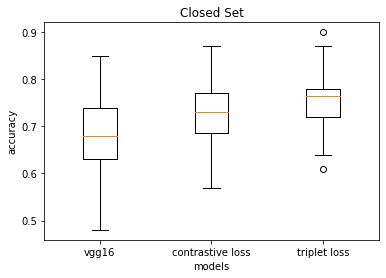

In [13]:
plt.boxplot([acc_vgg16, acc_cl_close, acc_tl_close], labels=['vgg16', 'contrastive loss', 'triplet loss'])
plt.xlabel('models')
plt.ylabel('accuracy')
plt.title('Closed Set')
plt.show()

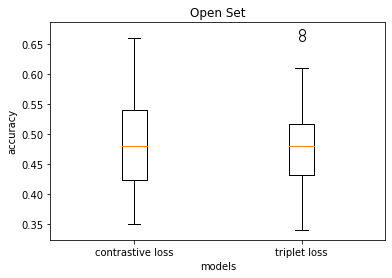

In [14]:
plt.boxplot([acc_cl_open, acc_tl_open], labels=['contrastive loss', 'triplet loss'])
plt.xlabel('models')
plt.ylabel('accuracy')
plt.title('Open Set')
plt.show()

In [15]:
!pip install autorank

# Closed Set

In [16]:
from autorank import autorank, plot_stats, create_report

results_closed = autorank(acc_closed, alpha = 0.05, verbose=False)
print(results_closed)

RankResult(rankdf=
                   meanrank    mean       std  ci_lower  ci_upper effect_size  \
triplet_loss           1.50  0.7570  0.063991  0.740267  0.773733         0.0   
constrastive_loss      1.92  0.7304  0.066883  0.713667  0.747133    0.406398   
vgg16                  2.58  0.6844  0.080081  0.667667  0.701133    1.001603   

                    magnitude  
triplet_loss       negligible  
constrastive_loss       small  
vgg16                   large  
pvalue=3.6172398866312876e-13
cd=None
omnibus=anova
posthoc=tukeyhsd
all_normal=True
pvals_shapiro=[0.8152614831924438, 0.9172025918960571, 0.5156088471412659]
homoscedastic=True
pval_homogeneity=0.24250144678716182
homogeneity_test=bartlett
alpha=0.05
alpha_normality=0.016666666666666666
num_samples=50
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_size=cohen_d)


/opt/conda/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


In [17]:
create_report(results_closed)

The statistical analysis was conducted for 3 populations with 50 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.516). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.243) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each population. Populations are significantly different if their confid

# Open Set

In [18]:
results_open = autorank(acc_open, alpha = 0.05, verbose=False)
print(results_open)

RankResult(rankdf=
                  meanrank    mean       std  ci_lower  ci_upper effect_size  \
contrastive_loss       1.5  0.4834  0.076841  0.458272  0.508528         0.0   
triplet_loss           1.5  0.4822  0.070632  0.459102  0.505298     0.01626   

                   magnitude  
contrastive_loss  negligible  
triplet_loss      negligible  
pvalue=0.8366645828442837
cd=None
omnibus=ttest
posthoc=None
all_normal=True
pvals_shapiro=[0.10172062367200851, 0.2643977105617523]
homoscedastic=True
pval_homogeneity=0.5576026789745605
homogeneity_test=bartlett
alpha=0.05
alpha_normality=0.025
num_samples=50
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_size=cohen_d)


In [19]:
create_report(results_open)

The statistical analysis was conducted for 2 populations with 50 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.102). Therefore, we assume that all populations are normal.
No check for homogeneity was required because we only have two populations.
Because we have only two populations and both populations are normal, we use the t-test to determine differences between the mean values of the populations and report the mean value (M)and the standard deviation (SD) for each population. 
We failed to reject the null hypothesis (p=0.837) of the paired t-test that the mean values of the populations contrastive_loss (M=0.483+-0.025, SD=0.077) and triplet_loss (M=0.482+-0.023, SD=0.071) are are equal. Therefore, we assume that there is no statistically significant difference between the mean values of the populations.
